# Import

In [204]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import glob, os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)
import random
import cv2

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

tqdm.pandas()
#import plotly.express as px
#import plotly.graph_objects as go
#import plotly.figure_factory as ff
#from plotly.subplots import make_subplots

#pip install torchsummary
from torchsummary import summary

# Check localization of data

In [205]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [206]:
data_dir = ''

In [207]:
# Verification of the number of Images 

# load filenames for human and dog images
size = 0
size = np.array(glob(data_dir+"images/*"))

# Check one image
#Image.open(open("/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg", 'rb'))

# print number of images in each dataset
print('There are %d total images.' % len(size))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

train_csv

There are 3642 total images.


image_id  healthy  multiple_diseases  rust  scab
0        Train_0        0                  0     0     1
1        Train_1        0                  1     0     0
2        Train_2        1                  0     0     0
3        Train_3        0                  0     1     0
4        Train_4        1                  0     0     0
...          ...      ...                ...   ...   ...
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

[1821 rows x 5 columns]

# Channel Distribution


In [208]:
SAMPLE_LEN = 100
IMAGE_PATH = data_dir + 'images/'

def load_image(image_id):
    file_path = image_id + ".jpg"
    #print(file_path)
    image = cv2.imread(IMAGE_PATH + file_path)
    #print(image)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_csv["image_id"][:SAMPLE_LEN].progress_apply(load_image)



100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


<Figure size 432x288 with 0 Axes>

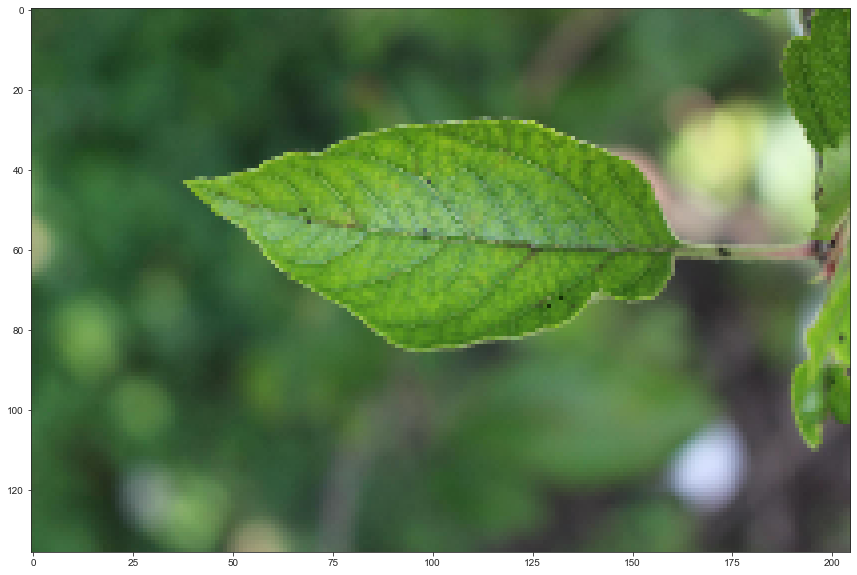

In [209]:

fig_one = plt.figure()
fig_one = plt.figure(figsize=(50,10))
ax_show = fig_one.add_subplot(111)
ax_show.imshow(cv2.resize(train_images[9], (205, 136)))


# Channel distribution

In [210]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]


## All channel value

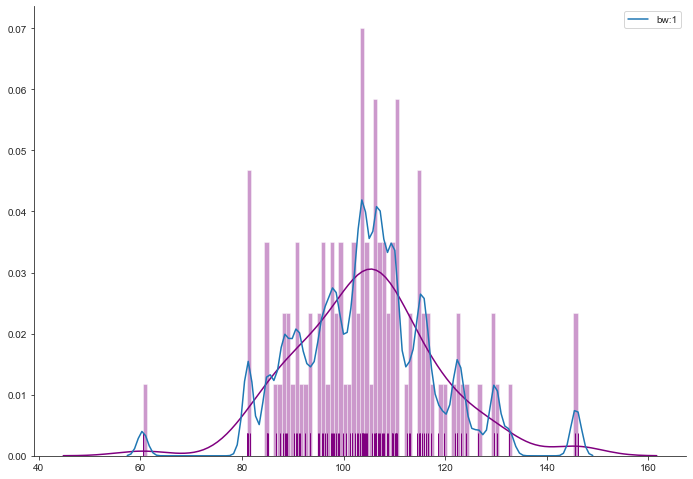

In [211]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(values, bins=100, kde=True, rug=True, color="purple")
sns.kdeplot(values, bw=1, label="bw:1")
#sns.kdeplot(values, bw=2, label="bw:2" )

sns.despine()

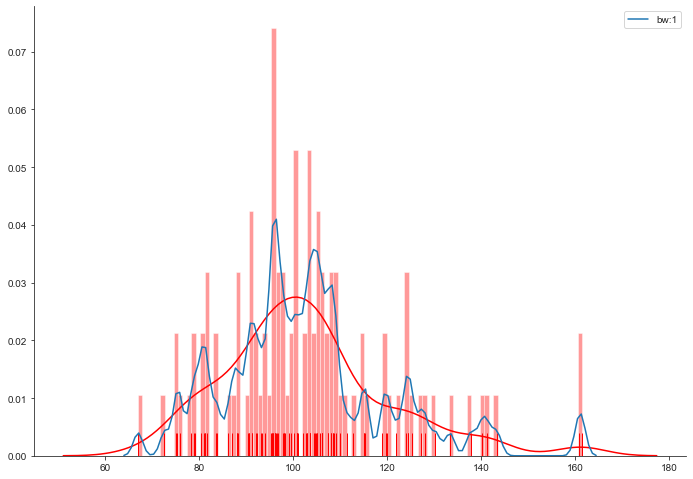

In [212]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(red_values, bins=100, kde=True, rug=True, color="red")
sns.kdeplot(red_values, bw=1, label="bw:1")

sns.despine()

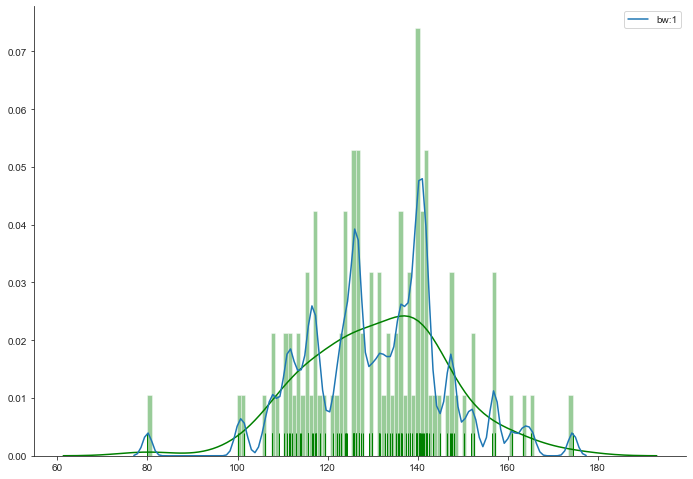

In [213]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(green_values, bins=100, kde=True, rug=True, color="green")
sns.kdeplot(green_values, bw=1, label="bw:1")

sns.despine()

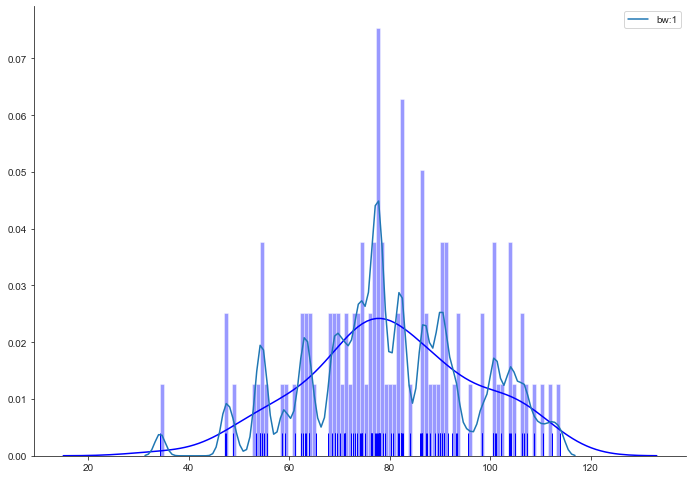

In [214]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(blue_values, bins=100, kde=True, rug=True, color="blue")
sns.kdeplot(blue_values, bw=1, label="bw:1")


sns.despine()

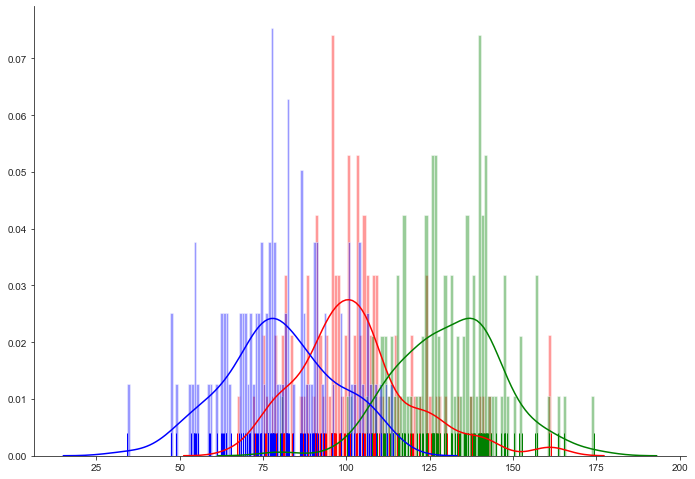

In [215]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(red_values, bins=100, kde=True, rug=True, color="red")
sns.distplot(green_values, bins=100, kde=True, rug=True, color="green")
sns.distplot(blue_values, bins=100, kde=True, rug=True, color="blue")

sns.despine()

## Local standardization


In [216]:
image = Image.open(os.path.join(data_dir+'images/Train_0.jpg'))
pixels = np.asarray(image)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))
# per-channel standardization of pixels
pixels = (pixels - means) / stds
# confirm it had the desired effect
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))

Means: [109.884463   125.92046489  54.53764058], Stds: [47.57227605 47.61807193 33.53314092]
Means: [2.24186867e-13 4.82158242e-14 2.12353946e-14], Stds: [1. 1. 1.]


# Creation of custom datasheet

In [269]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for 
        # image collection via CV2
    
        image_cv2 = cv2.imread(os.path.join(self.root, img_name), cv2.IMREAD_COLOR)
        
        image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
        
        
        if self.transform is not None:
            transformed = self.transform(image=image_cv2)
            image_cv2 = transformed['image']
            
        # define the label based on the idx
        if self.transform == train_transforms or self.transform == valid_transforms:
            label_target = self.data.iloc[idx, 1:5].values.astype('int64')
            label_target = np.argwhere(label_target ==1)
            label_target = label_target.item(0)
            label_target = torch.tensor(label_target)
            #print(label_target)
        else:
            label_target = torch.tensor(0)
        
        # Label of the data
        if self.transform == train_transforms or self.transform == valid_transforms:
            label = self.data.loc[idx, self.id]
            label = int(label[6:])
            label = torch.tensor(label)
        else:
            label = self.data.loc[idx, self.id]
            #print(label)
            label = int(label[5:])
            label = torch.tensor(label)
        
        return image_cv2, label_target, label

Size = 400

train_transforms = A.Compose([
    A.Resize(height=512, width=512, p=1.0),
    A.CenterCrop(height=Size, width=Size, p=1.0),
    RandomRotate90(p=0.5),
    Flip(p=0.5),
    Transpose(p=0.5),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.8),
    #OneOf([
    #    MotionBlur(p=0.1),
    #    MedianBlur(blur_limit=3, p=0.1),
    #    Blur(blur_limit=3, p=0.1),
    #], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    #OneOf([
    #    OpticalDistortion(p=0.3),
    #    GridDistortion(p=0.1),
    #    IAAPiecewiseAffine(p=0.3),
    #], p=0.2),
    #OneOf([
    #    CLAHE(clip_limit=2),
    #    IAASharpen(p=1.0),
    #    IAAEmboss(),
    #    RandomBrightnessContrast(1.0),
    #], p=1.0),
    IAASharpen(p=1.0),
    #HueSaturationValue(p=1.0),
    #RandomBrightnessContrast(0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
    #A.Normalize(mean=(0.406, 0.456, 0.485), std=(0.225, 0.224, 0.229), p=1.0),
    #A.Normalize(),
    ToTensorV2(p=1.0),
])
 
valid_transforms = A.Compose([
    A.Resize(height=Size, width=Size, p=1.0), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0), 
    ToTensorV2(p=1.0)
])
    
test_transforms = A.Compose([
    A.Resize(height=Size, width=Size, p=1.0), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0), 
    ToTensorV2(p=1.0)
])


params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
}

In [270]:
image_dataset = {x: CustomDataset(csv_file=data_dir+'train.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size = 32,  shuffle=True) 
               for x in ['train', 'valid', 'test']}

print('TRAINING')
img, lab_target, lab = image_dataset['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image at the first row: ', type(img))
print('image size at the first row: {}'.format(img.size()))
print('\nTarget at the first row: ', lab_target)
print('Target format at the first row: {}'.format(lab_target))
print('Target format at the first row: {}'.format(lab_target.shape))
print('\nLab at the first row: ', lab)
print('lab format at the first row: {}'.format(lab))
print('lab format at the first row: {}'.format(lab.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

images, labels_target, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('\nTaregt type on batch size = {}'.format(labels_target))
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)
print('\nlabels type on batch size = {}'.format(labels))
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = ', labels.shape)



TRAINING
DATASET
image at the first row:  torch.Size([3, 400, 400])
image at the first row:  <class 'torch.Tensor'>
image size at the first row: torch.Size([3, 400, 400])

Target at the first row:  tensor(3)
Target format at the first row: 3
Target format at the first row: torch.Size([])

Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([32, 3, 400, 400])

Taregt type on batch size = tensor([2, 2, 3, 2, 2, 3, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 3, 0, 2, 0, 2, 3, 3,
        3, 0, 2, 3, 3, 0, 0, 3])
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([32])

labels type on batch size = tensor([1547,  516,  870, 1373, 1613, 1259,  695, 1196,  421, 1378,  133, 1476,
         475,    9, 1158,  156, 1699, 1360, 

## Dataset Visualization

# tranform impact on image

1. the image 1449 target is healthy
2. the image 1578 target is rust
3. the image 1465 target is rust
4. the image 943 target is scab
5. the image 1113 target is rust
6. the image 186 target is scab
7. the image 1660 target is scab
8. the image 175 target is healthy
9. the image 118 target is rust
10. the image 467 target is rust
11. the image 1352 target is rust
12. the image 1214 target is healthy
13. the image 1427 target is rust
14. the image 355 target is scab
15. the image 927 target is scab
16. the image 1515 target is rust
17. the image 1041 target is rust
18. the image 573 target is healthy
19. the image 408 target is rust
20. the image 479 target is rust
21. the image 1546 target is healthy
22. the image 61 target is scab
23. the image 1648 target is multiple_diseases
24. the image 855 target is rust
25. the image 1630 target is rust
26. the image 348 target is healthy
27. the image 98 target is rust
28. the image 1148 target is rust
29. the image 668 target is rust
30. the i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

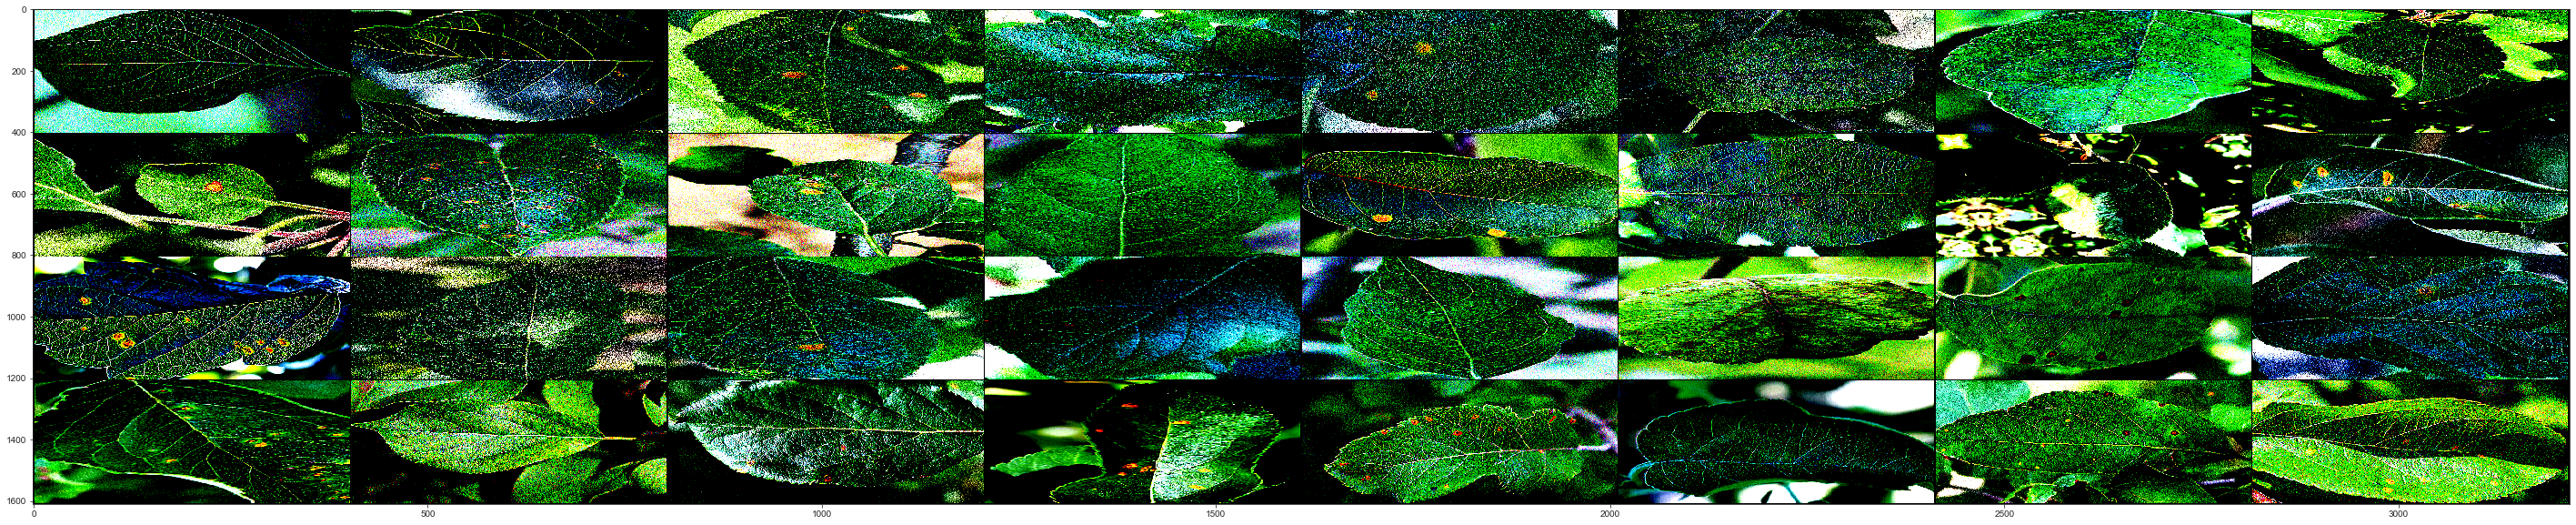

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

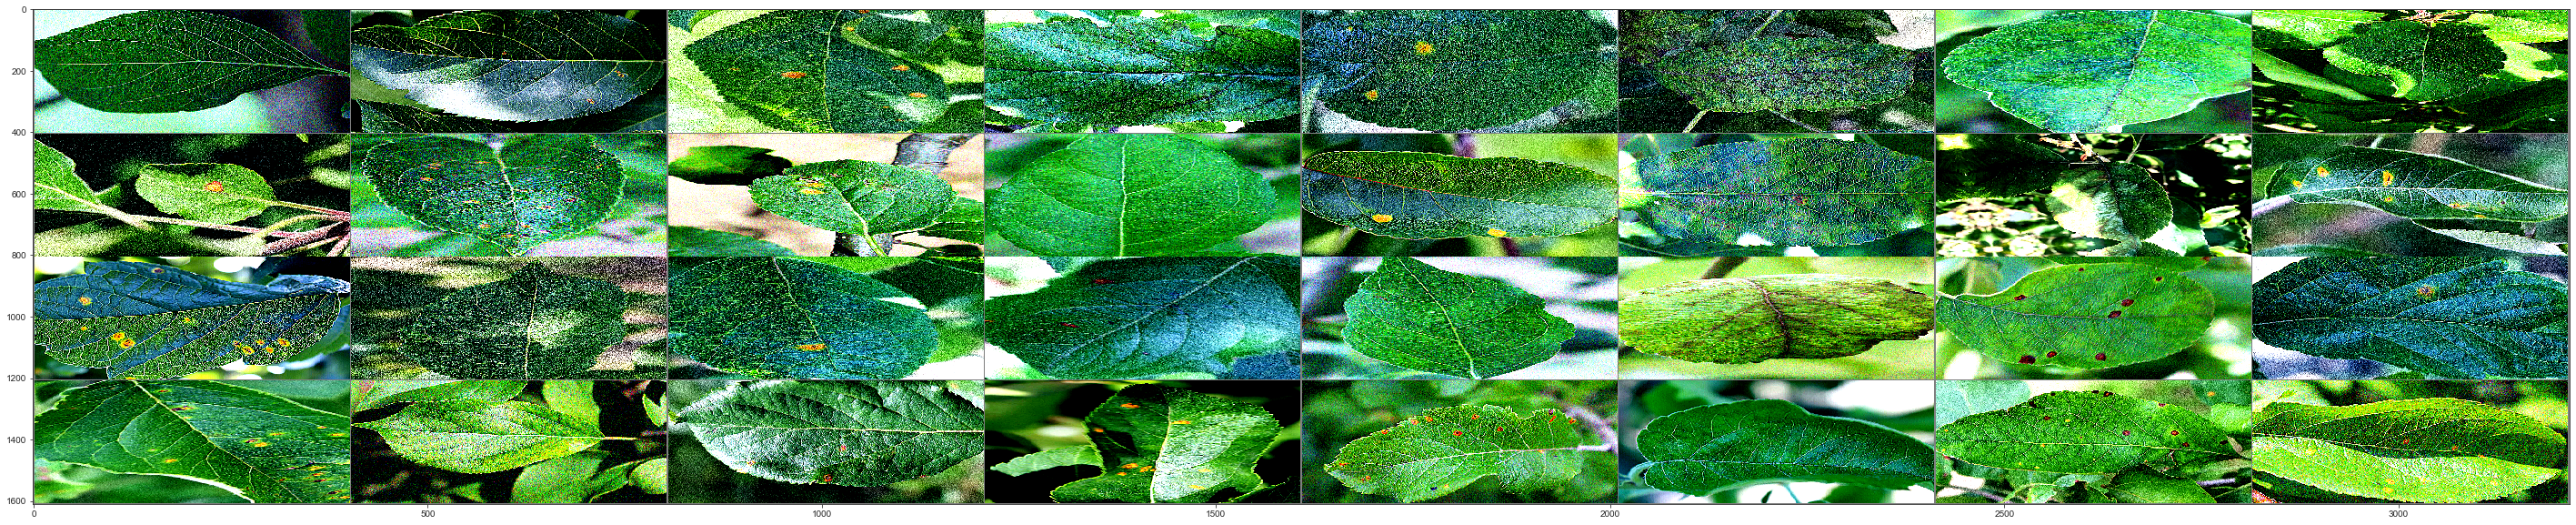

In [271]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(data_loader['train'])
#print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
#print('image test data',images_test_data)
images_target_label = images_test[1]
#print(len(images_target_label))
images_label = images_test[2]
#print(len(images_label))

for i in range(len(images_target_label)):
    print('{}. the image {} target is {}'.format(i+1,images_label[i].numpy(), classes[images_target_label[i].numpy()]))

def imshow(img):
    # image from transform
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()
    
    # image unormalize
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))

# Model

In [281]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CNN1
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv11 = nn.Conv2d(16, 16, 2, padding=0)
        self.conv111 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv1111 = nn.Conv2d(32, 32, 2, padding=0)
        
        # CNN2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 2, padding=0)
        self.conv222 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2222 = nn.Conv2d(128, 128, 2, padding=0)
        
        # CNN3
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv33 = nn.Conv2d(256, 256, 2, padding=0)
        self.conv333 = nn.Conv2d(256, 256, 2, padding=0)
     
        # CNN4
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv44 = nn.Conv2d(512, 512, 2, padding=0)
        self.conv444 = nn.Conv2d(512, 512, 2, padding=0)
        
        # CNN4
        #self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        #self.conv55 = nn.Conv2d(1024, 1024, 2, padding=0)
        #self.conv555 = nn.Conv2d(1024, 1024, 2, padding=0)
        
        #batchNorm
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        #self.batchnorm1024 = nn.BatchNorm2d(1024)
        #self.batchnorm2048 = nn.BatchNorm2d(2048)
        
        # Activation function
        #self.activate = F.leaky_relu()
        
        # Max pooling layer
        self.MAXpool = nn.MaxPool2d(3, 3)
        self.AVGpool = nn.AvgPool2d(3, 3)
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(512 * 3 * 3, 500)
        
        # linear layer (250 -> 4)
        self.fc2 = nn.Linear(500, 250)
        
        # linear layer (250 -> 4)
        self.fc3 = nn.Linear(250, 125)
        
        # linear layer (250 -> 4)
        self.fc4 = nn.Linear(125, 4)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5)
        
        # LogSoftmax
        self.LSM = nn.LogSoftmax()
    
    def forward(self, x):
        ## Define forward behavior
        # 1st CNN
        # 3 => 32
        x = self.conv1(x)
        x = F.relu6(x)
        x = self.conv11(x)
        x = F.relu6(x)
        x = self.batchnorm16(x)
        
        x = self.conv111(x)
        x = F.relu6(x)
        x = self.conv1111(x)
        x = F.relu6(x)
        x = self.batchnorm32(x)
        
        # MAXpool and Dropout
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 64 => 128
        x = self.conv2(x)
        x = F.relu6(x)
        x = self.conv22(x)
        x = F.relu6(x)
        x = self.batchnorm64(x)
        
        x = self.conv222(x)
        x = F.relu6(x)
        x = self.conv2222(x)
        x = F.relu6(x)
        x = self.batchnorm128(x)
        
        # MAXpool and Dropout
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 2nd Cnn
        # 128 => 256
        x = self.conv3(x)
        x = F.relu6(x)
        x = self.conv33(x)
        x = F.relu6(x)
        x = self.conv333(x)
        x = F.relu6(x)
        x = self.batchnorm256(x)
        
        # AVGpool and Dropout
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 32 => 64
        x = self.conv4(x)
        x = F.relu6(x)
        x = self.conv44(x)
        x = F.relu6(x)
        x = self.conv444(x)
        x = F.relu6(x)
        x = self.batchnorm512(x)        
        
        # AVGpool and Dropout
        x = self.AVGpool(x)
        x = self.dropout(x)
       
        # flatten image input
        print(x.shape)
        x = x.view(-1, 512 * 3 * 3)
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h4
        x = self.fc4(x)
        x = self.LSM(x)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_patho = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_patho.cuda()


In [282]:
summary(Net(),input_size=(3, 400, 400))

torch.Size([2, 512, 3, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
            Conv2d-2         [-1, 16, 399, 399]           1,040
       BatchNorm2d-3         [-1, 16, 399, 399]              32
            Conv2d-4         [-1, 32, 399, 399]           4,640
            Conv2d-5         [-1, 32, 398, 398]           4,128
       BatchNorm2d-6         [-1, 32, 398, 398]              64
         AvgPool2d-7         [-1, 32, 132, 132]               0
           Dropout-8         [-1, 32, 132, 132]               0
            Conv2d-9         [-1, 64, 132, 132]          18,496
           Conv2d-10         [-1, 64, 131, 131]          16,448
      BatchNorm2d-11         [-1, 64, 131, 131]             128
           Conv2d-12        [-1, 128, 131, 131]          73,856
           Conv2d-13        [-1, 128, 130, 130]          65,664
      BatchN

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:155: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


       LogSoftmax-36                    [-1, 4]               0
Total params: 6,746,669
Trainable params: 6,746,669
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.83
Forward/backward pass size (MB): 278.30
Params size (MB): 25.74
Estimated Total Size (MB): 305.87
----------------------------------------------------------------


In [222]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.001, momentum = 0.9)

In [223]:
LR_START = 0.0099
LR_MAX = 0.00005 # * num_replicas_in_sync
LR_MIN = 0.001
LR_RAMPUP_EPOCHS = 30
LR_SUSTAIN_EPOCHS = 40
LR_EXP_DECAY = 0.85

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr



In [245]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        LR = 0.0005
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target,_) in enumerate(loaders['train']):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            #optimizer.zero_grad()
            optim.SGD(model.parameters(), lr=LR, momentum=0.9).zero_grad()
            # add data.float() as the data is in ByteTensor format, which doesn't work the model data type
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            #optimizer.step()
            optim.SGD(model.parameters(), lr=LR, momentum=0.9).step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target, _) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        
        
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        
        
        
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            LR
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), 'version_1.pt'))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # return trained model
    return model

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 1.351708 	Validation Loss: 1.344007 	Time since the beginning 38.9 min 	Learning rate: 0.000500 
Validation loss decreased (inf --> 1.344007).  Saving model ...
Epoch: 2 	Training Loss: 1.338391 	Validation Loss: 1.330023 	Time since the beginning 65.8 min 	Learning rate: 0.000500 
Validation loss decreased (1.344007 --> 1.330023).  Saving model ...
Epoch: 3 	Training Loss: 1.326477 	Validation Loss: 1.316799 	Time since the beginning 91.0 min 	Learning rate: 0.000500 
Validation loss decreased (1.330023 --> 1.316799).  Saving model ...
Epoch: 4 	Training Loss: 1.310046 	Validation Loss: 1.303547 	Time since the beginning 116.7 min 	Learning rate: 0.000500 
Validation loss decreased (1.316799 --> 1.303547).  Saving model ...
Epoch: 5 	Training Loss: 1.297951 	Validation Loss: 1.290730 	Time since the beginning 141.8 min 	Learning rate: 0.000500 
Validation loss decreased (1.303547 --> 1.290730).  Saving model ...
Epoch: 6 	Training Loss: 1.279920 	Validation Lo

ValueError: x and y must have same first dimension, but have shapes (1,) and (30,)

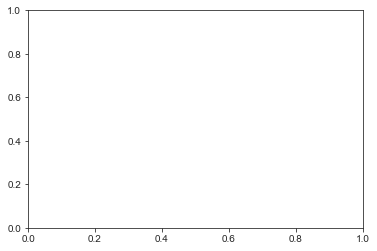

In [246]:
model_res = train(30, data_loader, model_patho, optimizer, criterion)



In [247]:
model_res = Net()

# load the model that got the best validation accuracy
model_res.load_state_dict(torch.load('version_1.pt'))

model_res

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv111): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv222): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv33): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv44): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (batchnorm16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

# TEST

In [248]:
image_dataset = {x: CustomDataset(csv_file=data_dir+'test.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size = 4,  shuffle=True) 
               for x in ['train', 'valid', 'test']}

print('TRAINING')
img_test, lab_target_test, lab_test = image_dataset['test'].__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img_test.shape)
print('image size at the first row: {}'.format(img_test.size()))
print('\nTarget at the first row: ', lab_target_test)
print('Target format at the first row: {}'.format(lab_target_test))
print('Target shape at the first row: {}'.format(lab_target_test.shape))
print('\nLab at the first row: ', lab_test)
print('lab format at the first row: {}'.format(lab_test))
print('lab format at the first row: {}'.format(lab_test.shape))

print()
print('Train Loader type')
test_iter = iter(data_loader['test'])
print(type(test_iter))


images_test, _, labels_test = test_iter.next()
print()
print('DATALOADER TEST')
print('images test',images_test[0][0][0][0])
print('images type on batch size = {}'.format(type(images_test)))
print('images shape on batch size = {}', images_test.shape)
print('\nlabels type on batch size = {}'.format(type(labels_test)))
print('labels shape on batch size = {}', labels_test)

TRAINING
DATASET TEST
image at the first row: {} torch.Size([3, 256, 256])
image size at the first row: torch.Size([3, 256, 256])

Target at the first row:  tensor(0)
Target format at the first row: 0
Target shape at the first row: torch.Size([])

Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER TEST
images test tensor(-0.8507)
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([4, 3, 256, 256])

labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} tensor([ 915,  598, 1176, 1373])


data_iter


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image test data tensor([[[[ 0.4851,  0.3138,  0.0398,  ...,  1.5982,  1.6838,  1.7009],
          [ 0.4851,  0.3138,  0.0569,  ...,  1.6495,  1.5639,  1.6153],
          [ 0.5364,  0.3138,  0.0056,  ...,  1.3242,  1.3584,  1.4612],
          ...,
          [-0.2513, -0.2684, -0.2171,  ..., -1.7069, -1.6042, -1.5014],
          [-0.3541, -0.3369, -0.2513,  ..., -1.5014, -1.3815, -1.3130],
          [-0.4397, -0.4568, -0.2513,  ..., -1.2959, -1.2274, -1.2103]],

         [[ 1.3606,  1.1681,  0.8354,  ...,  1.7983,  2.0259,  2.0434],
          [ 1.3606,  1.1681,  0.8354,  ...,  1.8333,  1.9384,  1.9909],
          [ 1.4132,  1.1681,  0.8004,  ...,  1.4482,  1.7633,  1.8683],
          ...,
          [ 0.6078,  0.6078,  0.6429,  ..., -1.2829, -1.1604, -1.0728],
          [ 0.5028,  0.5203,  0.5553,  ..., -1.0553, -0.9678, -0.8978],
          [ 0.3803,  0.4678,  0.5903,  ..., -0.9328, -0.8627, -0.8452]],

         [[ 0.3219,  0.1999, -0.0441,  ...,  0.6356,  0.7576,  0.7751],
          [ 0.

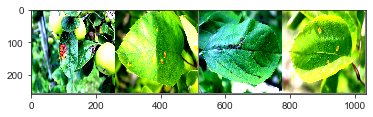

In [249]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(data_loader['test'])
print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
print('image test data',images_test_data)
images_test_label = images_test[1]
print(images_test_label)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [250]:
model_test = Net()
model_test.load_state_dict(torch.load('version_1.pt'))
model_test = model_test.eval()

out_fwd = model_test.forward(images_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
top_probs, top_labs = probs.topk(4)
print('top_probs:\n {} \n top_labs:\n {}'.format(top_probs, top_labs))
print(classes[top_labs[0][0].detach().numpy()])
print(classes[top_labs[1][0].detach().numpy()])
print(classes[top_labs[2][0].detach().numpy()])
print(classes[top_labs[3][0].detach().numpy()])


Result preditcion model on dataset:
 tensor([[-1.6308, -2.1066, -1.2086, -0.9572],
        [-1.3463, -2.7851, -0.8216, -1.4340],
        [-1.2425, -2.1734, -1.3631, -1.0739],
        [-1.5381, -2.7447, -0.7714, -1.3526]], grad_fn=<LogSoftmaxBackward>)

probs
 tensor([[0.1958, 0.1216, 0.2986, 0.3840],
        [0.2602, 0.0617, 0.4397, 0.2383],
        [0.2887, 0.1138, 0.2559, 0.3417],
        [0.2148, 0.0643, 0.4624, 0.2586]], grad_fn=<ExpBackward>)
top_probs:
 tensor([[0.3840, 0.2986, 0.1958, 0.1216],
        [0.4397, 0.2602, 0.2383, 0.0617],
        [0.3417, 0.2887, 0.2559, 0.1138],
        [0.4624, 0.2586, 0.2148, 0.0643]], grad_fn=<TopkBackward>) 
 top_labs:
 tensor([[3, 2, 0, 1],
        [2, 0, 3, 1],
        [3, 0, 2, 1],
        [2, 3, 0, 1]])
scab
rust
scab
rust


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Submission

In [251]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')

submission_df.iloc[:, 1:] = 0

submission_df.head()

image_id  healthy  multiple_diseases  rust  scab
0   Test_0        0                  0     0     0
1   Test_1        0                  0     0     0
2   Test_2        0                  0     0     0
3   Test_3        0                  0     0     0
4   Test_4        0                  0     0     0

In [252]:
submission_df_test = pd.read_csv(data_dir + 'sample_submission.csv')

model_test = Net()
model_test.load_state_dict(torch.load('version_1.pt'))
model_test = model_test.eval()

for idx, (data, _, label) in enumerate(data_loader['test']):
    images_data = data
    #print(images_data)
    label_data = label
    #print(label_data)   
    probs = torch.exp(model_test(images_data))
    #print(probs)
    label_data = label_data.numpy()
    #print(label_data)
    probs = probs.detach().numpy()
    #print(probs)
    for i in range(len(label_data)):
        #print(i)
        ind = label_data[i]
        #print(ind)
        res_probs = probs[i]
        #print(res_probs)
        res_add = ['Test_'+str(ind), res_probs[0], res_probs[1],res_probs[2],res_probs[3]]
        submission_df_test.loc[ind] = res_add         
        
pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(submission_df_test)
submission_df_test.to_csv(path_or_buf='sample_submission_version_1.csv', index=False)


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


       image_id   healthy  multiple_diseases      rust      scab
0        Test_0  0.247138           0.125637  0.344071  0.283153
1        Test_1  0.259834           0.129569  0.334350  0.276247
2        Test_2  0.131484           0.077536  0.207377  0.583603
3        Test_3  0.318728           0.105680  0.314767  0.260825
4        Test_4  0.257328           0.122653  0.354306  0.265713
...         ...       ...                ...       ...       ...
1816  Test_1816  0.135795           0.074662  0.214338  0.575206
1817  Test_1817  0.227691           0.110597  0.271116  0.390596
1818  Test_1818  0.260653           0.097048  0.234278  0.408021
1819  Test_1819  0.263569           0.102388  0.231036  0.403007
1820  Test_1820  0.430997           0.077974  0.313420  0.177608

[1821 rows x 5 columns]
